In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Colab Notebooks/Kaggle"

# Importing the Dataset from Kaggle

In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/Kaggle

/content/gdrive/My Drive/Colab Notebooks/Kaggle


In [ ]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 30.8MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 3.07MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 24.4MB/s]


In [ ]:
#Importing Libraries Used 
import numpy as np #
import pandas as pd # 
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from nltk import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train_df_master = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Kaggle/train.csv")
test_df_master = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Kaggle/test.csv")

In [ ]:
train_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Kaggle/train.csv")
test_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Kaggle/test.csv")

In [ ]:
len(train_df)

7613

In [ ]:
len(test_df)

3263

# Exploratory Data analysis and Cleaning

##EDA

**Visualizing Counts for each categories of tweet**

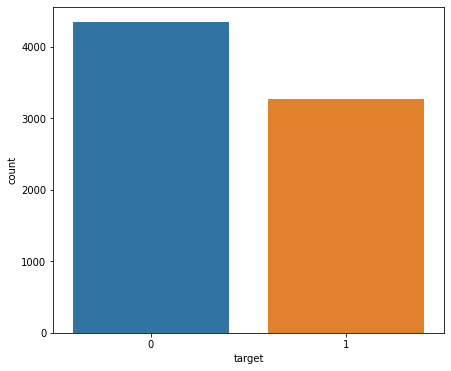

In [ ]:
fig = plt.figure(figsize=(7,6))
sns.countplot(train_df['target'])

In [ ]:
fig.savefig("CountsforEachCategory.pdf")

There are only two classes 0 and 1.The class distribution above shows that their are more tweets with class 0 ( No disaster) than class 1 ( disaster tweets)

**Number of words in a tweet**

Text(0.5, 1.0, 'disaster tweets')

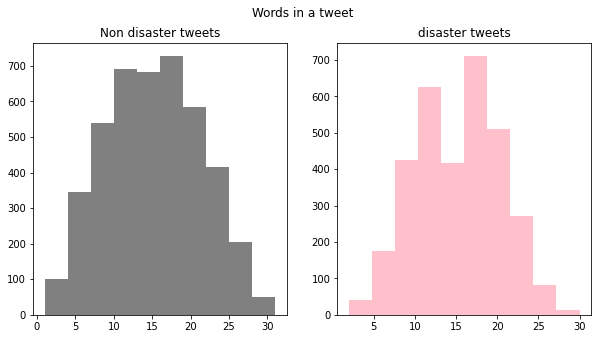

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweets = train_df[train_df['target']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweets, color='grey')
ax1.set_title('Non disaster tweets')
fig.suptitle('Words in a tweet')
tweets = train_df[train_df['target']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweets, color='pink')
ax2.set_title('disaster tweets')


We have Almost similar number of words in a Tweet.

In [ ]:
fig.savefig("WordsinaTweet.pdf")

In [ ]:
df_box = train_df[['text', 'target']]
df_box['length'] = train_df['text'].str.split().map(lambda x: len(x))
df_box.head()

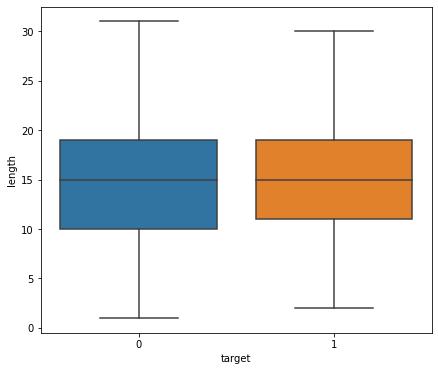

In [ ]:
fig = plt.figure(figsize=(7,6))
sns.boxplot(x='target', y='length', data=df_box)
plt.show()

In [ ]:
fig.savefig("BoxPlotWordsinaTweet.pdf")

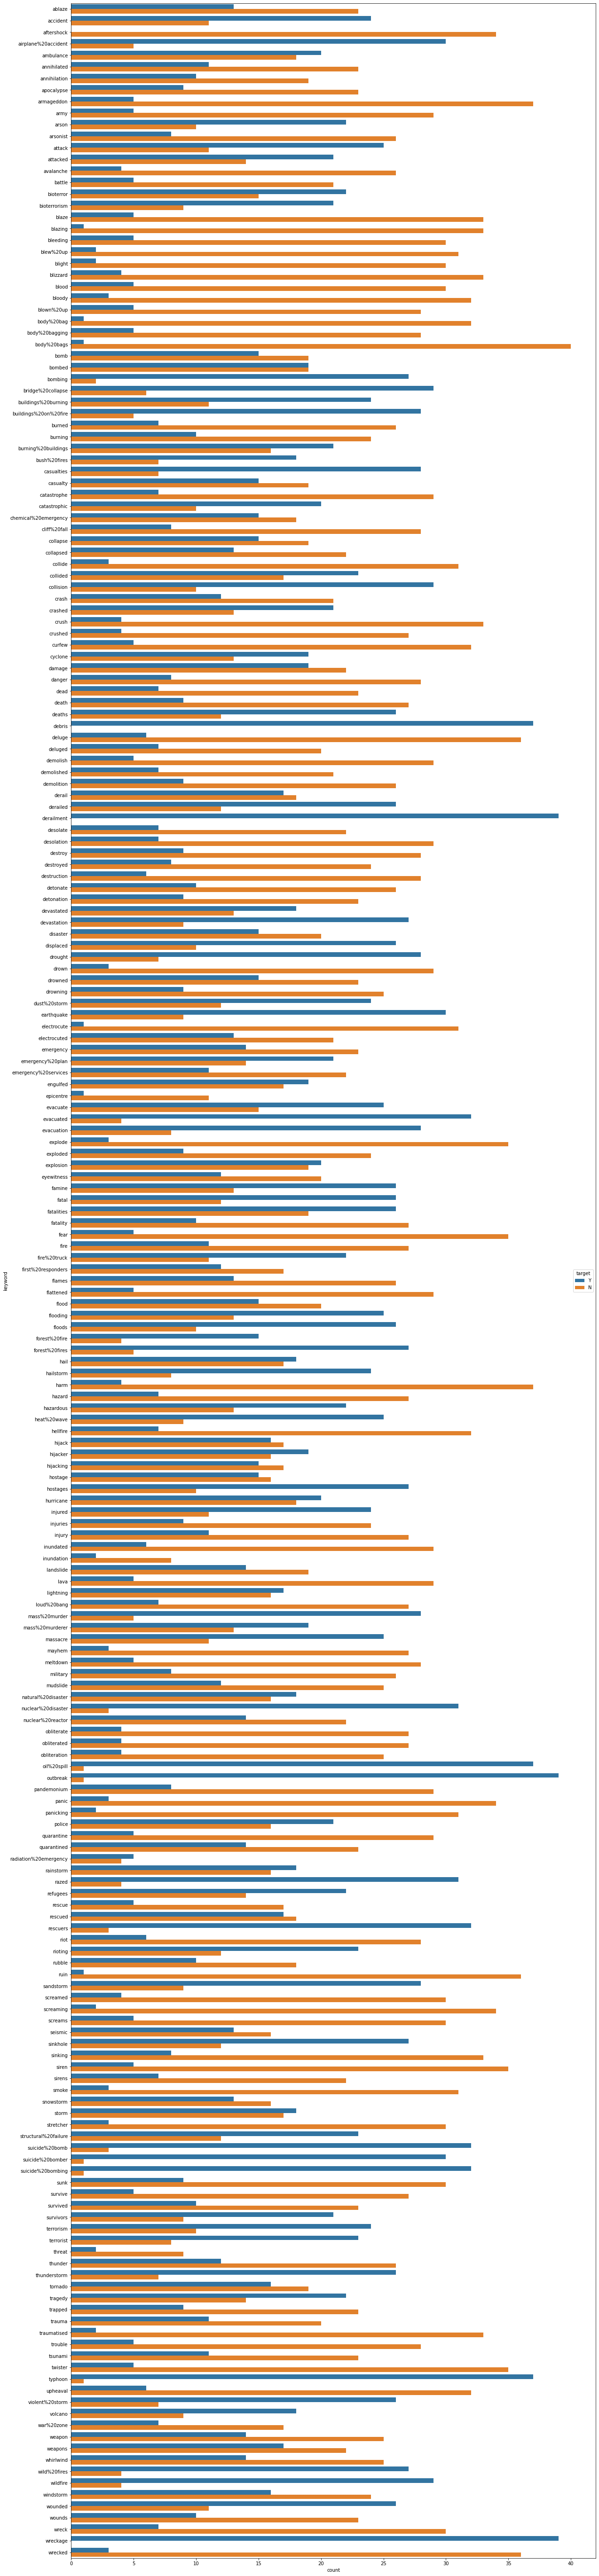

In [ ]:
#Distinct keywords in train dataset
cnt_plot =train_df[['keyword', 'target']]
cnt_plot = cnt_plot.dropna(axis=0)

cnt_plot['target'] = cnt_plot['target'].apply(lambda x: 'Y' if x ==1 else 'N')
plt.figure(figsize=(20, 100))
sns.countplot(y='keyword', hue='target', data=cnt_plot)
plt.show()

##Data Cleaning

Some basic cleaning such as removing punctuations,removing html tags ,urls ,digits and emojis

**Helper functions for Data Cleaning**

### Removing Emojis from Tweets

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

### Remove URLs from Tweets

In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

### Removing HTML

In [ ]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

### Removing Punctuations

In [ ]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

### Removing Digits

In [ ]:
def remove_digits(text):
    text = re.sub(r"\d", "", text) # to remove digits
    return text

### Applying helper functions on dataset

In [ ]:
# Removing Emojis from Dataset
train_df['text'] = train_df['text'].apply(lambda x: remove_emoji(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_emoji(x))

In [ ]:
# Removing URLs from Dataset
train_df['text']=train_df['text'].apply(lambda x : remove_URL(x))
test_df['text']=test_df['text'].apply(lambda x : remove_URL(x))

In [ ]:
# Removing HTML from Dataset
train_df['text']=train_df['text'].apply(lambda x : remove_html(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_html(x))

In [ ]:
# Removing Punctuations from DataSet
train_df['text']=train_df['text'].apply(lambda x : remove_punct(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_punct(x))

In [ ]:
# Removing Digits
train_df['text']=train_df['text'].apply(lambda x : remove_digits(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_digits(x))

In [ ]:
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1
5,8,NaN,NaN,RockyFire Update California Hwy closed in bo...,1
6,10,NaN,NaN,flood disaster Heavy rain causes flash floodin...,1
7,13,NaN,NaN,Im on top of the hill and I can see a fire in ...,1
8,14,NaN,NaN,Theres an emergency evacuation happening now i...,1
9,15,NaN,NaN,Im afraid that the tornado is coming to our area,1


**Checking Missing Values**

In [ ]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

Dropping Null values prior to model creation for Classifiers 

In [ ]:
# Dropping Location column
train_df = train_df.drop('location', axis=1)

In [ ]:
# Dropping all rows with null values for Keyword
train_df = train_df.dropna(axis=0)
print(len(train_df))

7552


In [ ]:
train_df.head()['text'].values

array(['bbcmtd Wholesale Markets ablaze ',
       'We always try to bring the heavy metal RT ',
       'AFRICANBAZE Breaking newsNigeria flag set ablaze in Aba ',
       'Crying out for more Set me ablaze',
       'On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE '],
      dtype=object)

## Using NTLK 
*Natural Language Toolkit *

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import nltk
nltk.download("popular") #Install Multiple nltk packages

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [ ]:
# Convert to Lower Case
train_df['text'] = train_df['text'].apply(lambda x: x.lower())

In [ ]:
stop = stopwords.words('english')
print(stop) #Printing Stop Words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

###Removing Stop Words and Tokenizing

In [ ]:
# Ref : https://stackabuse.com/removing-stop-words-from-strings-in-python/
from nltk.tokenize import word_tokenize
def remove_stopwords(text):
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stop]
    return tokens_without_sw

In [ ]:
print(remove_stopwords("Nick likes to play football, however he is not too fond of tennis"))

['Nick', 'likes', 'play', 'football', ',', 'however', 'fond', 'tennis']


In [ ]:
train_df['text']= train_df['text'].apply(lambda x: remove_stopwords(x))
test_df['text']= test_df['text'].apply(lambda x: remove_stopwords(x))

In [ ]:
train_df.head()

,id,keyword,text,target
31,48,ablaze,"[bbcmtd, wholesale, markets, ablaze]",1
32,49,ablaze,"[always, try, bring, heavy, metal, rt]",0
33,50,ablaze,"[africanbaze, breaking, newsnigeria, flag, set...",1
34,52,ablaze,"[crying, set, ablaze]",0
35,53,ablaze,"[plus, side, look, sky, last, night, ablaze]",0


###Lemmatizing and Stemming

Ref : https://towardsdatascience.com/stemming-vs-lemmatization-2daddabcb221

In [ ]:
train_df.head()

,id,keyword,text,target
31,48,ablaze,"[bbcmtd, wholesale, markets, ablaze]",1
32,49,ablaze,"[always, try, bring, heavy, metal, rt]",0
33,50,ablaze,"[africanbaze, breaking, newsnigeria, flag, set...",1
34,52,ablaze,"[crying, set, ablaze]",0
35,53,ablaze,"[plus, side, look, sky, last, night, ablaze]",0


In [ ]:
def return_corpus(df):
    stemmer = PorterStemmer()
    wordnet_lemmatizer = WordNetLemmatizer()

    # Remove stop words and stem the values
    df['text'] = df['text'].apply(lambda x: ' '.join(wordnet_lemmatizer.lemmatize(word) for word in word_tokenize(x) if not word in set(stopwords.words('english'))))
    
    return list(df['text'])

In [ ]:
corpus = return_corpus(train_df)
corpus[:3]

['Our Deeds Reason earthquake May ALLAH Forgive u',
 'Forest fire near La Ronge Sask Canada',
 'All resident asked shelter place notified officer No evacuation shelter place order expected']

In [ ]:
len(corpus)

7552

#Beginner's Approach

### Creating a Bag of Word Model

Ref : https://machinelearningmastery.com/gentle-introduction-bag-words-model/

Ref : https://towardsdatascience.com/a-simple-explanation-of-the-bag-of-words-model-b88fc4f4971

In [ ]:
cv = CountVectorizer(max_features = len(corpus))
#Create Bag of Words Model , here X represent bag of words
X = cv.fit_transform(corpus).todense()
y = train_df['target'].values

In [ ]:
print(X)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Split the training data in Train and Validation set

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.3, random_state=2020)

**Importing all Classifiers**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
df_AUC = pd.DataFrame( columns = ['Model Name', 'ROC AUC Score']) 

In [ ]:
df_AUC["Model Name"]

0             Gaussian Naive Bayes
1             K- Nearest neighbour
2                    Decision Tree
3              Logistic Regression
4                          XGBoost
5    Multinomial Naive bayes Model
6           RandomForestClassifier
Name: Model Name, dtype: object

### Gaussian Naive Bayes Model

In [ ]:
# Fitting Gaussian Naive Bayes to the Training set
classifier_gnb = GaussianNB()
classifier_gnb.fit(X_train, y_train)
# Predicting the Train data set results
y_pred_gnb = classifier_gnb.predict(X_test)

# Classification Reports
report_gnb = classification_report(y_test, y_pred_gnb)
print(report_gnb)
y_auc = roc_auc_score(y_test, y_pred_gnb)
print('Gaussian Naive Bayes Model: ROC AUC=%.3f' % (y_auc))
new_row = {'Model Name':'Gaussian Naive Bayes', 'ROC AUC Score':y_auc }
df_AUC = df_AUC.append(new_row, ignore_index=True)

              precision    recall  f1-score   support

           0       0.76      0.48      0.59      1282
           1       0.55      0.81      0.65      1002

    accuracy                           0.62      2284
   macro avg       0.66      0.64      0.62      2284
weighted avg       0.67      0.62      0.62      2284

Gaussian Naive Bayes Model: ROC AUC=0.643


### K-Nearest Neighbour

In [ ]:
# Fitting K- Nearest neighbour to the Training set
classifier_knn = KNeighborsClassifier(n_neighbors = 7, weights = 'distance',algorithm = 'brute')
classifier_knn.fit(X_train, y_train)
# Predicting the Train data set results
y_pred_knn = classifier_knn.predict(X_test)
# Classification Reports
report_knn = classification_report(y_test, y_pred_knn)
print(report_knn)
y_auc = roc_auc_score(y_test, y_pred_knn)
print('K- Nearest neighbour: ROC AUC=%.3f' % (y_auc))
new_row = {'Model Name':' K- Nearest neighbour', 'ROC AUC Score':y_auc }
df_AUC = df_AUC.append(new_row, ignore_index=True)

              precision    recall  f1-score   support

           0       0.65      0.98      0.78      1282
           1       0.91      0.32      0.47      1002

    accuracy                           0.69      2284
   macro avg       0.78      0.65      0.62      2284
weighted avg       0.76      0.69      0.64      2284

K- Nearest neighbour: ROC AUC=0.646


### Decision Tree Classifier

In [ ]:
# Fitting Decision Tree Models to the Training set
classifier_dt = DecisionTreeClassifier(criterion= 'gini',
                                           max_depth = 10, 
                                           splitter='best', 
                                           random_state=55)
classifier_dt.fit(X_train, y_train)
# Predicting the Train data set results
y_pred_dt = classifier_dt.predict(X_test)
# Classification Reports
report_dt = classification_report(y_test, y_pred_dt)
print(report_dt)
y_auc = roc_auc_score(y_test, y_pred_dt)
print('Decision Tree: ROC AUC=%.3f' % (y_auc))
new_row = {'Model Name':'Decision Tree', 'ROC AUC Score':y_auc }
df_AUC = df_AUC.append(new_row, ignore_index=True)

              precision    recall  f1-score   support

           0       0.62      0.95      0.75      1282
           1       0.81      0.27      0.40      1002

    accuracy                           0.65      2284
   macro avg       0.71      0.61      0.58      2284
weighted avg       0.70      0.65      0.60      2284

Decision Tree: ROC AUC=0.608


### Logistic Regression Model

In [ ]:
# Fitting Logistic Regression Model to the Training set
classifier_lr = LogisticRegression()
classifier_lr.fit(X_train, y_train)
# Predicting the Train data set results
y_pred_lr = classifier_lr.predict(X_test)
# Classification Reports
report_lr = classification_report(y_test, y_pred_lr)
print(report_lr)
y_auc = roc_auc_score(y_test, y_pred_lr)
print('Logistic Regression Model: ROC AUC=%.3f' % (y_auc))
new_row = {'Model Name':'Logistic Regression', 'ROC AUC Score':y_auc }
df_AUC = df_AUC.append(new_row, ignore_index=True)


              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1282
           1       0.81      0.68      0.74      1002

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.78      2284
weighted avg       0.79      0.79      0.78      2284

Logistic Regression Model: ROC AUC=0.776


### XGBoost Classifier

In [ ]:
# Fitting XGBoost Model to the Training set
classifier_xgb = XGBClassifier(max_depth=6,learning_rate=0.3,random_state=123,n_jobs=4)
classifier_xgb.fit(X_train, y_train)
# Predicting the Train data set results
y_pred_xgb = classifier_xgb.predict(X_test)
# Classification Reports
report_xgb = classification_report(y_test, y_pred_xgb)
print(report_xgb)
y_auc = roc_auc_score(y_test, y_pred_xgb)
print('XGBoost Model: ROC AUC=%.3f' % (y_auc))
new_row = {'Model Name':'XGBoost', 'ROC AUC Score':y_auc }
df_AUC = df_AUC.append(new_row, ignore_index=True)

              precision    recall  f1-score   support

           0       0.74      0.90      0.82      1282
           1       0.83      0.60      0.70      1002

    accuracy                           0.77      2284
   macro avg       0.79      0.75      0.76      2284
weighted avg       0.78      0.77      0.77      2284

XGBoost Model: ROC AUC=0.754


### Multinomial Naive Bayes

In [ ]:
# Fitting multinomial naive bayes Model to the Training set
classifier_mnb = MultinomialNB()
classifier_mnb.fit(X_train, y_train)
# Predicting the Train data set results
y_pred_mnb = classifier_mnb.predict(X_test)
# Classification Reports
report_mnb = classification_report(y_test, y_pred_mnb)
print(report_mnb)
y_auc = roc_auc_score(y_test, y_pred_mnb)
print('Multinomial naive bayes Model: ROC AUC=%.3f' % (y_auc))
new_row = {'Model Name':'Multinomial Naive bayes Model', 'ROC AUC Score':y_auc }
df_AUC = df_AUC.append(new_row, ignore_index=True)

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1282
           1       0.79      0.71      0.75      1002

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.79      2284
weighted avg       0.79      0.79      0.79      2284

Multinomial naive bayes Model: ROC AUC=0.785


### Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(
                             max_depth=4,
                             random_state=100,
                             min_samples_leaf=100, 
                             min_samples_split=100,
                             n_estimators=50)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
# Classification Reports
report_rfc = classification_report(y_test, y_pred_rfc)
print(report_rfc)
y_auc = roc_auc_score(y_test, y_pred_rfc)
print('RandomForestClassifier: ROC AUC=%.3f' % (y_auc))
new_row = {'Model Name':'RandomForestClassifier', 'ROC AUC Score':y_auc }
df_AUC = df_AUC.append(new_row, ignore_index=True)

              precision    recall  f1-score   support

           0       0.56      1.00      0.72      1282
           1       0.00      0.00      0.00      1002

    accuracy                           0.56      2284
   macro avg       0.28      0.50      0.36      2284
weighted avg       0.32      0.56      0.40      2284

RandomForestClassifier: ROC AUC=0.500


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_AUC

,Model Name,ROC AUC Score
0,Gaussian Naive Bayes,0.643208
1,K- Nearest neighbour,0.645984
2,Decision Tree,0.607774
3,Logistic Regression,0.775967
4,XGBoost,0.753815
5,Multinomial Naive bayes Model,0.784634
6,RandomForestClassifier,0.500000


##ROC Score Comparison of Various Classifiers

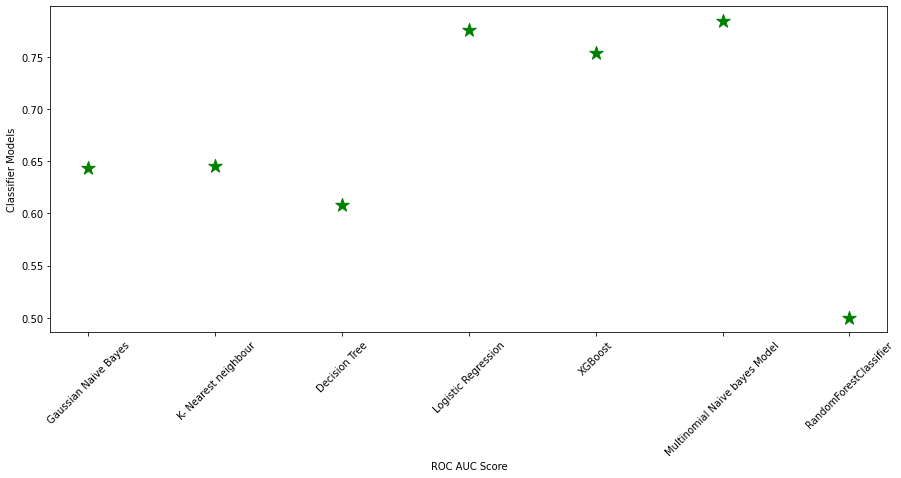

In [ ]:
fig = plt.figure(figsize=(15,6))
plt.scatter(df_AUC["Model Name"], df_AUC["ROC AUC Score"],color='Green',s=200, marker='*')
plt.xticks(rotation=45)

# Plot axes labels and show the plot
plt.xlabel('ROC AUC Score')
plt.ylabel('Classifier Models')
plt.show()

In [ ]:
fig.savefig("ClassifiersComparison.pdf")

#Neural Network Approach

##**TPU**

In [ ]:
import tensorflow as tf
print("GPU Available: ", tf.test.is_gpu_available())
print("Tensorflow version: ", tf.__version__)
print("Keras Version: ", tf.keras.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
  strategy = tf.distribute.get_strategy()

print("Number of accelerators: ", strategy.num_replicas_in_sync)
num_replicas = strategy.num_replicas_in_sync

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  False
Tensorflow version:  2.3.0
Keras Version:  2.4.0
INFO:tensorflow:Initializing the TPU system: grpc://10.79.112.114:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.112.114:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


In [ ]:
if tpu:
  BATCH_SIZE = 64 * num_replicas
  print("Batch Size TPU: ",BATCH_SIZE)
else:
  BATCH_SIZE = 512

EPOCHS = 1000

Batch Size TPU:  512


##**GloVe for Vectorization**


Ref : https://nlp.stanford.edu/projects/glove/

Ref: https://medium.com/analytics-vidhyaword-vectorization-using-glove-76919685ee0b

Ref : https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

Creating Corpus for Glove.

In [ ]:
train_df_new_format= train_df

In [ ]:
from tqdm import tqdm
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        corpus.append(tweet)
    return corpus

In [ ]:
train_df_new_format.text

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [people, receive, wildfires, evacuation, order...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [ariaahrary, thetawniest, control, wild, fires...
7610                             [utckm, volcano, hawaii]
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, homes, razed, northern, california, w...
Name: text, Length: 7613, dtype: object

In [ ]:
 corpus = create_corpus(train_df_new_format)

100%|██████████| 7552/7552 [00:00<00:00, 1299929.57it/s]


In [ ]:
print(corpus)

[['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us'], ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'], ['residents', 'asked', 'shelter', 'place', 'notified', 'officers', 'evacuation', 'shelter', 'place', 'orders', 'expected'], ['people', 'receive', 'wildfires', 'evacuation', 'orders', 'california'], ['got', 'sent', 'photo', 'ruby', 'alaska', 'smoke', 'wildfires', 'pours', 'school'], ['rockyfire', 'update', 'california', 'hwy', 'closed', 'directions', 'due', 'lake', 'county', 'fire', 'cafire', 'wildfires'], ['flood', 'disaster', 'heavy', 'rain', 'causes', 'flash', 'flooding', 'streets', 'manitou', 'colorado', 'springs', 'areas'], ['im', 'top', 'hill', 'see', 'fire', 'woods'], ['theres', 'emergency', 'evacuation', 'happening', 'building', 'across', 'street'], ['im', 'afraid', 'tornado', 'coming', 'area'], ['three', 'people', 'died', 'heat', 'wave', 'far'], ['haha', 'south', 'tampa', 'getting', 'flooded', 'hah', 'wait', 'second', 'live', 'south', 'tampa', 'gon',

In [ ]:
# Ref : https://stackoverflow.com/questions/50060241/how-to-use-glove-word-embeddings-file-on-google-colaboratory
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-08-10 05:03:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-10 05:03:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-10 05:03:13--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

glove

In [ ]:
!unzip glove*.zip

In [ ]:
# Ref : https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove#Data-Cleaning 
#Glove embedding is basically a file. So in first part, it just loads a file & separate word : vector value ( which is 100 D here)
embedding_dict={}
with open('/content/gdrive/My Drive/Colab Notebooks/Kaggle/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors 
f.close()

In [ ]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 17067


In [ ]:
#They're trying to build embedding matrix ( as LSTM models consume matrix in embedding layer )
#. Size of that matrix will be (number of unique words in corpus * 100 )
# they are just going over words and filling up matrix. If a word in given corpus is part of embedding matrix 
#we got a hit in Glove embedding & we can get corresponding vector from Glove. If there is no matching word in embedding 
#then it's an embedding miss & that word will have default vector ( which is a vector of size 1 * 100 with all zeros)

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec
            

100%|██████████| 17067/17067 [00:00<00:00, 451208.23it/s]


##Split the available Data into Train and Test Set

In [ ]:
print(tweet_pad[1:])

[[   95   231   697 ...     0     0     0]
 [ 6203   341  6204 ...     0     0     0]
 [ 6205   205   547 ...     0     0     0]
 ...
 [16611  6078  6077 ...     0     0     0]
 [16612   143  5054 ...     0     0     0]
 [ 1972  2260   355 ...     0     0     0]]


In [ ]:
type(tweet_pad)
tweet_pad.shape

(7552, 50)

In [ ]:
train_df_new_format.shape

(7552, 4)

In [ ]:
train=tweet_pad[:train_df_new_format.shape[0]]
test=tweet_pad[train_df_new_format.shape[0]:]

In [ ]:
train.shape,test.shape

((7552, 50), (0, 50))

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(train,train_df_new_format['target'].values,test_size=0.10)
print('Shape of train',X_train.shape)
print("Shape of Test ",X_test.shape)

Shape of train (6796, 50)
Shape of Test  (756, 50)


##Model 1 - LSTM 

In [ ]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           1661300   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,703,605
Trainable params: 42,305
Non-trainable params: 1,661,300
_________________________________________________________________


In [ ]:
history=model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.2,verbose=2)

In [ ]:
#model.save('model1.h5')
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(15)

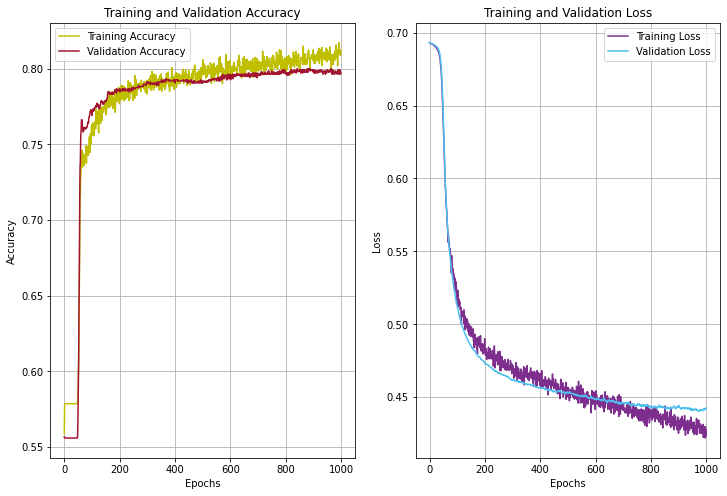

In [ ]:
epochs_range = range(EPOCHS)

fig=plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy', color=[0.75, 0.75, 0])
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', color= 	[0.6350, 0.0780, 0.1840])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss', color=	[0.4940, 0.1840, 0.5560])
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', color= [0.3010, 0.7450, 0.9330])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()
#fig.savefig('TrainHistory_LSTM_1.pdf')


In [ ]:
# test data for test_accuracy
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy*100))

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(test_accuracy*100))

Training Accuracy: 82.5633
Testing Accuracy:  80.4233


In [ ]:
y_pred_lstm = model.predict(X_test)
y_pred_lstm_round = y_pred_lstm.round().astype('int')
# Classification Reports
report_rfc = classification_report(y_test, y_pred_lstm_round)
print(report_rfc)
y_auc = roc_auc_score(y_test, y_pred_lstm_round)
print('LSTM: ROC AUC=%.3f' % (y_auc))


              precision    recall  f1-score   support

           0       0.78      0.90      0.84       422
           1       0.84      0.69      0.76       334

    accuracy                           0.80       756
   macro avg       0.81      0.79      0.80       756
weighted avg       0.81      0.80      0.80       756

LSTM: ROC AUC=0.792


##Model 2 - Bidirectional LSTM



Ref : https://stackoverflow.com/questions/43035827/whats-the-difference-between-a-bidirectional-lstm-and-an-lstm

In [ ]:
model_BiLSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_matrix.shape[1], input_length = MAX_LEN, weights = [embedding_matrix],
                             trainable = False),                   
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.2)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=8, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid")    
])
model_BiLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1576500   
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 64)            34048     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,611,077
Trainable params: 34,577
Non-trainable params: 1,576,500
_______________________________________

In [ ]:
model_BiLSTM.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.RMSprop(lr=4*0.0001), metrics = ['acc'])

In [ ]:
history=model_BiLSTM.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.2,verbose=1)

Epoch 1/1000
 2/11 [====>.........................] - ETA: 4s - loss: 0.6877 - acc: 0.5537WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_train_batch_end` time: 0.0928s). Check your callbacks.


11/11 [==============================] - ETA: 0s - loss: 0.6763 - acc: 0.6014WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0007s vs `on_test_batch_end` time: 0.0192s). Check your callbacks.


11/11 [==============================] - 2s 198ms/step - loss: 0.6763 - acc: 0.6014 - val_loss: 0.6617 - val_acc: 0.6471
Epoch 2/1000
11/11 [==============================] - 1s 85ms/step - loss: 0.6397 - acc: 0.6727 - val_loss: 0.6163 - val_acc: 0.7228
Epoch 3/1000
11/11 [==============================] - 1s 84ms/step - loss: 0.6042 - acc: 0.7149 - val_loss: 0.5824 - val_acc: 0.7522
Epoch 4/1000
11/11 [==============================] - 1s 82ms/step - loss: 0.5739 - acc: 0.7380 - val_loss: 0.5524 - val_acc: 0.7699
Epoch 5/1000
11/11 [==============================] - 1s 83ms/step - loss: 0.5486 - acc: 0.7518 - val_loss: 0.5314 - val_acc: 0.7691
Epoch 6/1000
11/11 [==============================] - 1s 82ms/step - loss: 0.5259 - acc: 0.7667 - val_loss: 0.5136 - val_acc: 0.7787
Epoch 7/1000
11/11 [==============================] - 1s 83ms/step - loss: 0.5118 - acc: 0.7702 - val_loss: 0.5004 - val_acc: 0.7809
Epoch 8/1000
11/11 [==============================] - 1s 83ms/step - loss: 0.4972

In [ ]:
# Ref : https://stackoverflow.com/questions/51463383/buffered-data-was-truncated-after-reaching-the-output-size-limit
#model_BiLSTM.save('model2.h5')
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(15)

,loss,acc,val_loss,val_acc,epoch
985,0.079104,0.970567,1.049738,0.786765,985
986,0.073608,0.970567,1.085685,0.786029,986
987,0.071241,0.972958,1.089743,0.787500,987
988,0.073892,0.972038,1.126927,0.783088,988
989,0.076731,0.971118,1.094051,0.784559,989
990,0.074751,0.971486,1.111160,0.775735,990
991,0.076318,0.972038,1.071586,0.786029,991
992,0.074606,0.974062,1.096072,0.786765,992
993,0.074991,0.971118,1.063169,0.790441,993
994,0.075099,0.972774,1.102756,0.785294,994


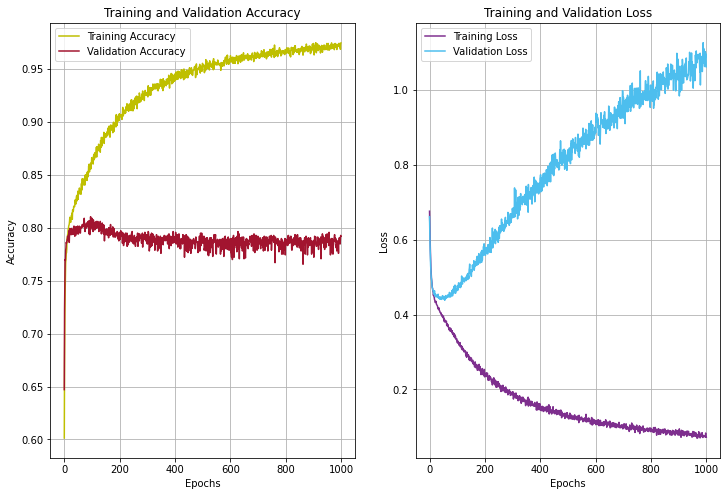

In [ ]:
epochs_range = range(EPOCHS)

fig=plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['acc'], label='Training Accuracy', color=[0.75, 0.75, 0])
plt.plot(epochs_range, history.history['val_acc'], label='Validation Accuracy', color= 	[0.6350, 0.0780, 0.1840])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss', color=	[0.4940, 0.1840, 0.5560])
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', color= [0.3010, 0.7450, 0.9330])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# test data for test_accuracy
loss, accuracy = model_BiLSTM.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy*100))

val_loss, val_accuracy = model_BiLSTM.evaluate(X_test, y_test, verbose=False)
print("Validation Accuracy:  {:.4f}".format(val_accuracy*100))

Training Accuracy: 94.7911
Validation Accuracy:  76.9841


##Model 3 - Bidirectional LSTM



There was a lot of overfitting in the Model 2 , hence trying adding more regularization by increasing the drop out.

In [ ]:
model_BiLSTM_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_matrix.shape[1], input_length = MAX_LEN, weights = [embedding_matrix],
                             trainable = False),                   
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True, dropout = 0.6, recurrent_dropout = 0.6)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(units=8, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid")     
])
model_BiLSTM_2.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 100)           1576500   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 50, 128)           84480     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 1,662,021
Trainable params: 85,521
Non-trainable params: 1,576,500
_______________________________________

In [ ]:
model_BiLSTM_2.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.RMSprop(lr=4*0.0001), metrics = ['acc'])

In [ ]:
#define early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [ ]:
history=model_BiLSTM_2.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=75,validation_split=0.2,verbose=1)

Epoch 1/75
 2/11 [====>.........................] - ETA: 4s - loss: 0.7126 - acc: 0.4609WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0009s vs `on_train_batch_end` time: 0.1184s). Check your callbacks.


11/11 [==============================] - ETA: 0s - loss: 0.6895 - acc: 0.5350WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0009s vs `on_test_batch_end` time: 0.0309s). Check your callbacks.


11/11 [==============================] - 3s 242ms/step - loss: 0.6895 - acc: 0.5350 - val_loss: 0.6559 - val_acc: 0.6375
Epoch 2/75
11/11 [==============================] - 1s 119ms/step - loss: 0.6633 - acc: 0.6133 - val_loss: 0.6265 - val_acc: 0.7037
Epoch 3/75
11/11 [==============================] - 1s 121ms/step - loss: 0.6367 - acc: 0.6494 - val_loss: 0.6001 - val_acc: 0.7346
Epoch 4/75
11/11 [==============================] - 1s 122ms/step - loss: 0.6123 - acc: 0.6933 - val_loss: 0.5663 - val_acc: 0.7551
Epoch 5/75
11/11 [==============================] - 1s 120ms/step - loss: 0.5877 - acc: 0.7110 - val_loss: 0.5352 - val_acc: 0.7669
Epoch 6/75
11/11 [==============================] - 1s 120ms/step - loss: 0.5644 - acc: 0.7320 - val_loss: 0.5016 - val_acc: 0.7809
Epoch 7/75
11/11 [==============================] - 1s 121ms/step - loss: 0.5379 - acc: 0.7500 - val_loss: 0.4899 - val_acc: 0.7728
Epoch 8/75
11/11 [==============================] - 1s 122ms/step - loss: 0.5230 - acc:

In [ ]:
# Ref : https://stackoverflow.com/questions/51463383/buffered-data-was-truncated-after-reaching-the-output-size-limit
model_BiLSTM_2.save('model_BiLSTM_2_80.h5')

import pandas as pd

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(15)

,loss,acc,val_loss,val_acc,epoch
60,0.458688,0.791207,0.446009,0.798529,60
61,0.459958,0.795254,0.440625,0.802941,61
62,0.455931,0.800037,0.440170,0.804412,62
63,0.463788,0.788447,0.439894,0.804412,63
64,0.460861,0.790287,0.441435,0.800000,64
65,0.458566,0.795622,0.436665,0.802941,65
66,0.457597,0.791759,0.445124,0.805147,66
67,0.453365,0.798381,0.438575,0.804412,67
68,0.458842,0.795622,0.435618,0.805882,68
69,0.450058,0.801141,0.440004,0.807353,69


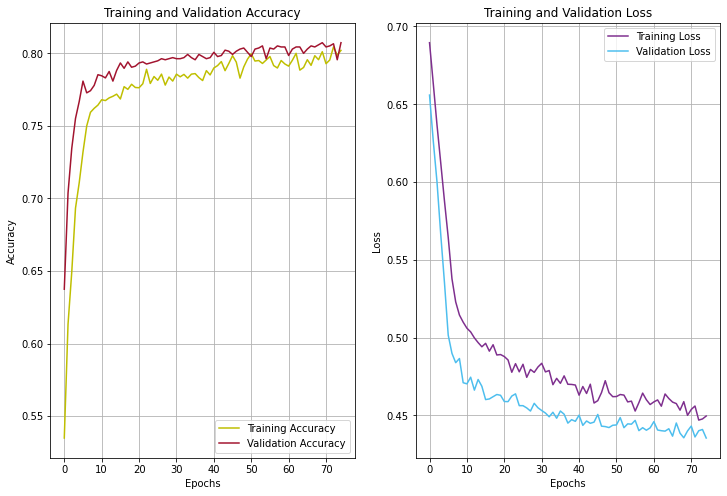

In [ ]:
epochs_range = range(75)

fig=plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['acc'], label='Training Accuracy', color=[0.75, 0.75, 0])
plt.plot(epochs_range, history.history['val_acc'], label='Validation Accuracy', color= 	[0.6350, 0.0780, 0.1840])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss', color=	[0.4940, 0.1840, 0.5560])
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', color= [0.3010, 0.7450, 0.9330])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()
fig.savefig('TrainHistory_BILSTM_80.pdf')

In [ ]:
# test data for test_accuracy
loss, accuracy = model_BiLSTM_2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy*100))

test_loss, test_accuracy = model_BiLSTM_2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(test_accuracy*100))

Training Accuracy: 82.0188
Testing Accuracy:  80.5556


In [ ]:
y_pred_blstm = model_BiLSTM_2.predict(X_test)
y_pred_blstm_round = y_pred_lstm.round().astype('int')
# Classification Reports
report_rfc = classification_report(y_test, y_pred_blstm_round)
print(report_rfc)
y_auc = roc_auc_score(y_test, y_pred_blstm_round)
print('BiLSTM: ROC AUC=%.3f' % (y_auc))


              precision    recall  f1-score   support

           0       0.78      0.90      0.84       422
           1       0.84      0.69      0.76       334

    accuracy                           0.80       756
   macro avg       0.81      0.79      0.80       756
weighted avg       0.81      0.80      0.80       756

BiLSTM: ROC AUC=0.792


##Model 4 - Bidirectional LSTM


Fine Tunning the hyperparameters to increase accuracy

In [ ]:
model_BiLSTM_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_matrix.shape[1], input_length = MAX_LEN, weights = [embedding_matrix],
                             trainable = False),                   
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True, dropout = 0.6, recurrent_dropout = 0.6)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(units=8, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid")     
])
model_BiLSTM_3.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 100)           1576500   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 50, 128)           84480     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 9         
Total params: 1,662,021
Trainable params: 85,521
Non-trainable params: 1,576,500
_______________________________________

In [ ]:
model_BiLSTM_3.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.RMSprop(lr=4*0.0003), metrics = ['acc'])

In [ ]:
#define early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)


In [ ]:
history=model_BiLSTM_3.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=100,validation_split=0.2,verbose=1)

Epoch 1/100
 2/11 [====>.........................] - ETA: 4s - loss: 0.7005 - acc: 0.5127WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_train_batch_end` time: 0.1220s). Check your callbacks.


11/11 [==============================] - ETA: 0s - loss: 0.6608 - acc: 0.6074WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_test_batch_end` time: 0.0303s). Check your callbacks.


11/11 [==============================] - 3s 238ms/step - loss: 0.6608 - acc: 0.6074 - val_loss: 0.5926 - val_acc: 0.7485
Epoch 2/100
11/11 [==============================] - 1s 121ms/step - loss: 0.5770 - acc: 0.7193 - val_loss: 0.5299 - val_acc: 0.7647
Epoch 3/100
11/11 [==============================] - 1s 120ms/step - loss: 0.5309 - acc: 0.7460 - val_loss: 0.5124 - val_acc: 0.7757
Epoch 4/100
11/11 [==============================] - 1s 119ms/step - loss: 0.5156 - acc: 0.7686 - val_loss: 0.4879 - val_acc: 0.7824
Epoch 5/100
11/11 [==============================] - 1s 121ms/step - loss: 0.5076 - acc: 0.7666 - val_loss: 0.4769 - val_acc: 0.7824
Epoch 6/100
11/11 [==============================] - 1s 120ms/step - loss: 0.4970 - acc: 0.7734 - val_loss: 0.4661 - val_acc: 0.7904
Epoch 7/100
11/11 [==============================] - 1s 121ms/step - loss: 0.4948 - acc: 0.7759 - val_loss: 0.4746 - val_acc: 0.7824
Epoch 8/100
11/11 [==============================] - 1s 121ms/step - loss: 0.4882

In [ ]:
# Ref : https://stackoverflow.com/questions/51463383/buffered-data-was-truncated-after-reaching-the-output-size-limit
#model_BiLSTM_2.save('model_BiLSTM_2_80.h5')
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(15)

,loss,acc,val_loss,val_acc,epoch
85,0.397425,0.826527,0.443727,0.801471,85
86,0.393665,0.830574,0.444691,0.803676,86
87,0.389023,0.831494,0.452823,0.800000,87
88,0.394985,0.826895,0.438021,0.800000,88
89,0.394683,0.827815,0.447403,0.802206,89
90,0.399542,0.827815,0.449071,0.794853,90
91,0.397128,0.828182,0.447551,0.800735,91
92,0.392574,0.828734,0.448544,0.804412,92
93,0.386479,0.831678,0.447788,0.806618,93
94,0.389028,0.834621,0.445299,0.809559,94


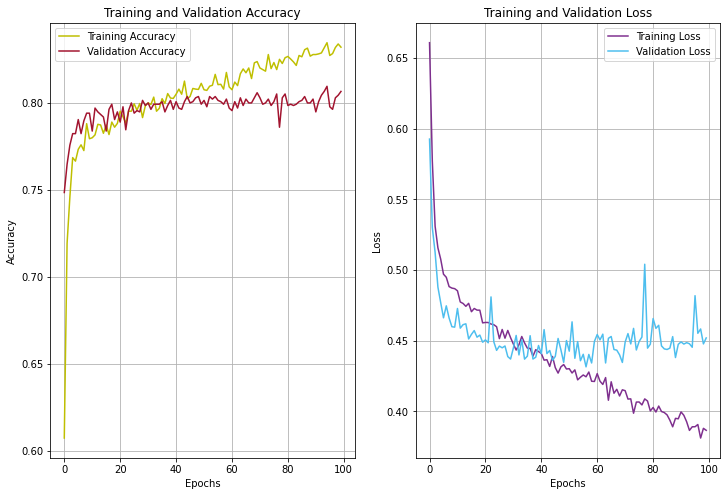

In [ ]:
epochs_range = range(100)

fig=plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['acc'], label='Training Accuracy', color=[0.75, 0.75, 0])
plt.plot(epochs_range, history.history['val_acc'], label='Validation Accuracy', color= 	[0.6350, 0.0780, 0.1840])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss', color=	[0.4940, 0.1840, 0.5560])
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', color= [0.3010, 0.7450, 0.9330])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# test data for test_accuracy
loss, accuracy = model_BiLSTM_3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy*100))

test_loss, test_accuracy = model_BiLSTM_3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(test_accuracy*100))

Training Accuracy: 85.5798
Testing Accuracy:  81.0847


In [ ]:
model_BiLSTM_3.save('model_BiLSTM_3_81.h5')

In [ ]:
model_BiLSTM_3 = tf.keras.models.load_model("model_BiLSTM_3_81.h5")

In [ ]:
y_pred_blstm = model_BiLSTM_3.predict(X_test)
y_pred_blstm_round = y_pred_blstm.round().astype('int')
# Classification Reports
report_rfc = classification_report(y_test, y_pred_blstm_round)
print(report_rfc)
y_auc = roc_auc_score(y_test, y_pred_blstm_round)
print('BiLSTM: ROC AUC=%.3f' % (y_auc))


##Model 5 - Bidirectional LSTM (Better)



Increasing EPOCs and using early stopping.

In [ ]:
model_BiLSTM_5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_matrix.shape[1], input_length = MAX_LEN, weights = [embedding_matrix],
                             trainable = False),                   
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True, dropout = 0.6, recurrent_dropout = 0.6)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(units=8, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid")    
])
model_BiLSTM_5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           1706800   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 128)           84480     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,792,321
Trainable params: 85,521
Non-trainable params: 1,706,800
_______________________________________

In [ ]:
model_BiLSTM_5.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.RMSprop(lr=4*0.0001), metrics = ['acc'])

In [ ]:
#define early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=16)

In [ ]:
history=model_BiLSTM_5.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.15,verbose=1,callbacks = [callback])

Epoch 1/1000
 2/12 [====>.........................] - ETA: 0s - loss: 0.7094 - acc: 0.5098WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_train_batch_end` time: 0.1176s). Check your callbacks.


12/12 [==============================] - ETA: 0s - loss: 0.6885 - acc: 0.5542WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0009s vs `on_test_batch_end` time: 0.0301s). Check your callbacks.


12/12 [==============================] - 2s 150ms/step - loss: 0.6885 - acc: 0.5542 - val_loss: 0.6598 - val_acc: 0.7098
Epoch 2/1000
12/12 [==============================] - 1s 107ms/step - loss: 0.6658 - acc: 0.6096 - val_loss: 0.6216 - val_acc: 0.7412
Epoch 3/1000
12/12 [==============================] - 1s 109ms/step - loss: 0.6337 - acc: 0.6619 - val_loss: 0.5765 - val_acc: 0.7598
Epoch 4/1000
12/12 [==============================] - 1s 110ms/step - loss: 0.6066 - acc: 0.6875 - val_loss: 0.5451 - val_acc: 0.7559
Epoch 5/1000
12/12 [==============================] - 1s 108ms/step - loss: 0.5749 - acc: 0.7251 - val_loss: 0.5199 - val_acc: 0.7627
Epoch 6/1000
12/12 [==============================] - 1s 109ms/step - loss: 0.5525 - acc: 0.7299 - val_loss: 0.4978 - val_acc: 0.7716
Epoch 7/1000
12/12 [==============================] - 1s 108ms/step - loss: 0.5343 - acc: 0.7490 - val_loss: 0.4845 - val_acc: 0.7716
Epoch 8/1000
12/12 [==============================] - 1s 108ms/step - loss:

In [ ]:
# Ref : https://stackoverflow.com/questions/51463383/buffered-data-was-truncated-after-reaching-the-output-size-limit
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(15)

,loss,acc,val_loss,val_acc,epoch
51,0.456858,0.794494,0.446136,0.791176,51
52,0.459126,0.792417,0.461670,0.785294,52
53,0.462824,0.791378,0.445993,0.791176,53
54,0.451725,0.798823,0.451263,0.788235,54
55,0.463538,0.791032,0.445628,0.801961,55
56,0.459015,0.789301,0.444930,0.793137,56
57,0.450113,0.798650,0.444856,0.800000,57
58,0.449538,0.797091,0.451821,0.792157,58
59,0.456789,0.798650,0.453056,0.794118,59
60,0.451360,0.797265,0.445443,0.793137,60


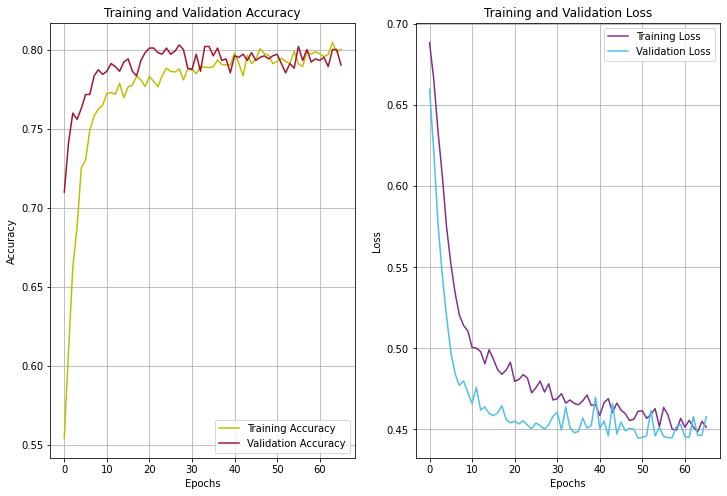

In [ ]:
epochs_range = range(66)

fig=plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['acc'], label='Training Accuracy', color=[0.75, 0.75, 0])
plt.plot(epochs_range, history.history['val_acc'], label='Validation Accuracy', color= 	[0.6350, 0.0780, 0.1840])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss', color=	[0.4940, 0.1840, 0.5560])
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', color= [0.3010, 0.7450, 0.9330])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()
#fig.savefig('TrainingHistory_BiLSTM_83.pdf')

In [ ]:
model_BiLSTM_5.save('model_BiLSTM_5_83.h5')
# test data for test_accuracy
loss, accuracy = model_BiLSTM_5.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy*100))

val_loss, val_accuracy = model_BiLSTM_5.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(val_accuracy*100))

Training Accuracy: 81.8717
Testing Accuracy:  83.3333


In [ ]:
y_pred_blstm = model_BiLSTM_5.predict(X_test)
y_pred_blstm_round = y_pred_blstm.round().astype('int')
# Classification Reports
report_rfc = classification_report(y_test, y_pred_blstm_round)
print(report_rfc)
y_auc = roc_auc_score(y_test, y_pred_blstm_round)
print('BiLSTM: ROC AUC=%.3f' % (y_auc))


              precision    recall  f1-score   support

           0       0.84      0.89      0.86       440
           1       0.83      0.76      0.79       316

    accuracy                           0.83       756
   macro avg       0.83      0.82      0.83       756
weighted avg       0.83      0.83      0.83       756

BiLSTM: ROC AUC=0.822


In [ ]:
X_test.shape

(762, 50)

In [ ]:
# Loading the saved model
#y_score = model_BiLSTM_final.predict(X_test)
model_BiLSTM_final = tf.keras.models.load_model("model_BiLSTM_5_83.h5")
y_score = model_BiLSTM_final.predict(X_test)

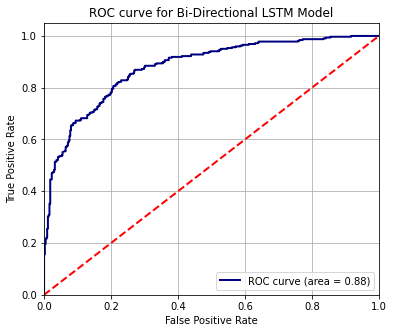

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test,y_score)
roc_auc = auc(fpr, tpr)
fig=plt.figure(figsize=(6, 5))
#plt.figure()
plt.plot(fpr, tpr, color= 'navy', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color= 'red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.title('ROC curve for Bi-Directional LSTM Model')
plt.legend(loc="lower right")
plt.show()
fig.savefig('ROC_BiLSTM_83_1.pdf')

In [ ]:
print(confusion_matrix(y_test,y_score_round) )

[[367  68]
 [ 91 230]]


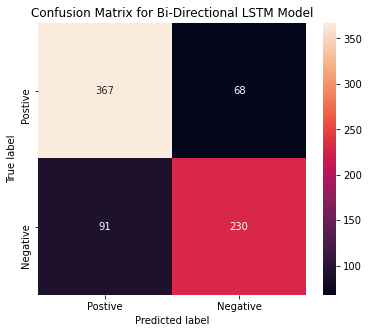

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
y_score_round = y_score.round().astype('int')
# Creates a confusion matrix
cm = confusion_matrix(y_test,y_score_round) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Postive','Negative'], 
                     columns = ['Postive','Negative'])

fig = plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('Confusion Matrix for Bi-Directional LSTM Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
fig.savefig('ConfusionMatrix_BiLSTM_final.pdf')

##Model 6 - Bidirectional LSTM



Changing the layers configurations

In [ ]:
model_BiLSTM_6 = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_matrix.shape[1], input_length = MAX_LEN, weights = [embedding_matrix],
                             trainable = False),                   
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True, dropout = 0.6, recurrent_dropout = 0.6)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(units=8, activation="relu"),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(units=1, activation="sigmoid")    
])
model_BiLSTM_6.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1706800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 128)           84480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 50, 8)             1032      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,792,321
Trainable params: 85,521
Non-trainable params: 1,706,800
_______________________________________

In [ ]:
model_BiLSTM_6.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.RMSprop(lr=4*0.0001), metrics = ['acc'])

In [ ]:
#define early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=16)

In [ ]:
history=model_BiLSTM_6.fit(X_train,y_train,batch_size=256,epochs=EPOCHS,validation_split=0.15,verbose=1,callbacks = [callback])

Epoch 1/1000
 2/23 [=>............................] - ETA: 1s - loss: 0.8213 - acc: 0.4180WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0011s vs `on_train_batch_end` time: 0.0909s). Check your callbacks.


23/23 [==============================] - ETA: 0s - loss: 0.6886 - acc: 0.5670WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0006s vs `on_test_batch_end` time: 0.0184s). Check your callbacks.


23/23 [==============================] - 2s 104ms/step - loss: 0.6886 - acc: 0.5670 - val_loss: 0.6378 - val_acc: 0.6402
Epoch 2/1000
23/23 [==============================] - 2s 82ms/step - loss: 0.6031 - acc: 0.6970 - val_loss: 0.5895 - val_acc: 0.7098
Epoch 3/1000
23/23 [==============================] - 2s 81ms/step - loss: 0.5581 - acc: 0.7349 - val_loss: 0.5372 - val_acc: 0.7637
Epoch 4/1000
23/23 [==============================] - 2s 82ms/step - loss: 0.5242 - acc: 0.7581 - val_loss: 0.4933 - val_acc: 0.7784
Epoch 5/1000
23/23 [==============================] - 2s 81ms/step - loss: 0.4981 - acc: 0.7730 - val_loss: 0.4734 - val_acc: 0.7892
Epoch 6/1000
23/23 [==============================] - 2s 81ms/step - loss: 0.4915 - acc: 0.7713 - val_loss: 0.4713 - val_acc: 0.7824
Epoch 7/1000
23/23 [==============================] - 2s 81ms/step - loss: 0.4885 - acc: 0.7713 - val_loss: 0.4584 - val_acc: 0.7951
Epoch 8/1000
23/23 [==============================] - 2s 81ms/step - loss: 0.4836

In [ ]:
# Ref : https://stackoverflow.com/questions/51463383/buffered-data-was-truncated-after-reaching-the-output-size-limit
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(15)

,loss,acc,val_loss,val_acc,epoch
47,0.437072,0.804363,0.443605,0.797059,47
48,0.441090,0.801939,0.443761,0.796078,48
49,0.441646,0.796399,0.439379,0.800000,49
50,0.439818,0.801766,0.441476,0.806863,50
51,0.441966,0.805748,0.440110,0.800980,51
52,0.443089,0.798650,0.440919,0.798039,52
53,0.430627,0.806440,0.441453,0.800980,53
54,0.434723,0.803843,0.441133,0.803922,54
55,0.431623,0.808691,0.440732,0.802941,55
56,0.428888,0.808345,0.443639,0.799020,56


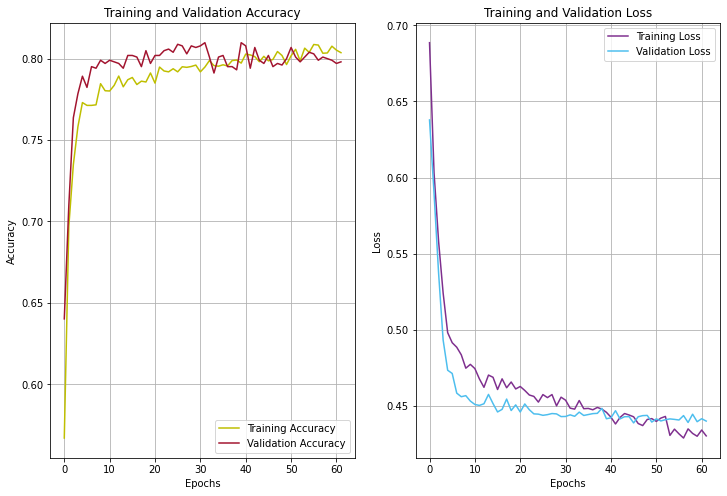

In [ ]:
epochs_range = range(62)

fig=plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['acc'], label='Training Accuracy', color=[0.75, 0.75, 0])
plt.plot(epochs_range, history.history['val_acc'], label='Validation Accuracy', color= 	[0.6350, 0.0780, 0.1840])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss', color=	[0.4940, 0.1840, 0.5560])
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', color= [0.3010, 0.7450, 0.9330])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()
fig.savefig('TrainingHistory_BiLSTM_82.pdf')

In [ ]:
model_BiLSTM_6.save('model_BiLSTM_6_82.h5')
# test data for test_accuracy
loss, accuracy = model_BiLSTM_6.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy*100))

val_loss, val_accuracy = model_BiLSTM_6.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(val_accuracy*100))

Training Accuracy: 82.6810
Testing Accuracy:  82.8042


In [ ]:
y_pred_blstm = model_BiLSTM_6.predict(X_test)
y_pred_blstm_round = y_pred_blstm.round().astype('int')
# Classification Reports
report_rfc = classification_report(y_test, y_pred_blstm_round)
print(report_rfc)
y_auc = roc_auc_score(y_test, y_pred_blstm_round)
print('BiLSTM: ROC AUC=%.3f' % (y_auc))


              precision    recall  f1-score   support

           0       0.82      0.90      0.86       440
           1       0.84      0.73      0.78       316

    accuracy                           0.83       756
   macro avg       0.83      0.81      0.82       756
weighted avg       0.83      0.83      0.83       756

BiLSTM: ROC AUC=0.814


In [ ]:
# Loading the saved model
model_BiLSTM_4 = tf.keras.models.load_model("model4_82.h5")
y_score = model_BiLSTM_4.predict(X_test)

<Figure size 864x576 with 0 Axes>

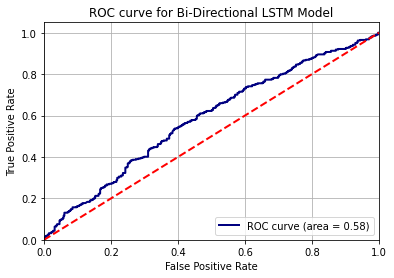

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test,y_score)
roc_auc = auc(fpr, tpr)
fig=plt.figure(figsize=(12, 8))
plt.figure()
plt.plot(fpr, tpr, color= 'navy', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color= 'red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.title('ROC curve for Bi-Directional LSTM Model')
plt.legend(loc="lower right")
plt.show()


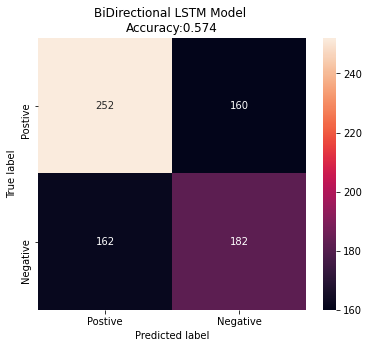

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
y_score_round = y_score.round().astype('int')
# Creates a confusion matrix
cm = confusion_matrix(y_test,y_score_round) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Postive','Negative'], 
                     columns = ['Postive','Negative'])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('BiDirectional LSTM Model \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_score_round)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
fig.savefig('ConfusionMatrix_BiLSTM.pdf')

In [ ]:
print(confusion_matrix(y_test,y_score_round) )

[[252 160]
 [162 182]]



**Gated Recurrent Unit**





Ref : https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

Ref :https://datascience.stackexchange.com/questions/14581/when-to-use-gru-over-lstm#:~:text=The%20key%20difference%20between%20a,%2C%20output%20and%20forget%20gates).

Ref : https://arxiv.org/pdf/1412.3555v1.pdf

**Notes:**
GRUs train faster and perform better than LSTMs on less training data if you are doing language modeling.
GRUs are simpler and thus easier to modify, for example adding new gates in case of additional input to the network. It's just less code in general.
LSTMs should in theory remember longer sequences than GRUs and outperform them in tasks requiring modeling long-distance relations.

##Model 7 - Gated Recurrent Unit

In [ ]:
model_GRU_6 = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_matrix.shape[1], input_length = MAX_LEN, weights = [embedding_matrix],
                             trainable = False),   
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(264,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(264,activation='elu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(264,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid') 
])
model_GRU_6.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           1706800   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               63744     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

In [ ]:
model_GRU_6.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.RMSprop(lr=4*0.001), metrics = ['acc'])

In [ ]:
#define early stopping callback
#callback = EarlyStopping(monitor = 'val_loss', patience = 4)
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
# history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5),
#                     epochs=10, batch_size=1, callbacks=[callback],
#                     verbose=0)
# #include it in your models training
#history = model_BiLSTM_4.fit(X_train, y_train, validation_split = .2, epochs = 50, callbacks = [callback])

In [ ]:
history=model_GRU_6.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split = .2,verbose=1)

Epoch 1/1000
 2/10 [=====>........................] - ETA: 3s - loss: 0.9522 - acc: 0.5195WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0010s vs `on_train_batch_end` time: 0.1121s). Check your callbacks.


10/10 [==============================] - ETA: 0s - loss: 1.0892 - acc: 0.4907WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_test_batch_end` time: 0.0419s). Check your callbacks.


10/10 [==============================] - 3s 291ms/step - loss: 1.0892 - acc: 0.4907 - val_loss: 0.7612 - val_acc: 0.5484
Epoch 2/1000
10/10 [==============================] - 1s 120ms/step - loss: 0.7347 - acc: 0.5339 - val_loss: 0.7930 - val_acc: 0.4516
Epoch 3/1000
10/10 [==============================] - 1s 117ms/step - loss: 0.7296 - acc: 0.5352 - val_loss: 0.8723 - val_acc: 0.5484
Epoch 4/1000
10/10 [==============================] - 1s 119ms/step - loss: 0.7236 - acc: 0.5389 - val_loss: 0.7596 - val_acc: 0.5484
Epoch 5/1000
10/10 [==============================] - 1s 118ms/step - loss: 0.7186 - acc: 0.5428 - val_loss: 0.6746 - val_acc: 0.4524
Epoch 6/1000
10/10 [==============================] - 1s 117ms/step - loss: 0.5683 - acc: 0.7233 - val_loss: 0.5356 - val_acc: 0.7543
Epoch 7/1000
10/10 [==============================] - 1s 117ms/step - loss: 0.4761 - acc: 0.7947 - val_loss: 0.8505 - val_acc: 0.7320
Epoch 8/1000
10/10 [==============================] - 1s 117ms/step - loss:

In [ ]:
# Ref : https://stackoverflow.com/questions/51463383/buffered-data-was-truncated-after-reaching-the-output-size-limit
#model_GRU_6.save('modelGRU_6.h5')
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(15)

,loss,acc,val_loss,val_acc,epoch
985,0.029466,0.986134,2.507301,0.765922,985
986,0.026156,0.986548,2.779180,0.765095,986
987,0.023343,0.986962,2.893351,0.766749,987
988,0.023587,0.986341,3.007520,0.767577,988
989,0.026039,0.987376,2.822077,0.762614,989
990,0.026092,0.986134,2.714174,0.765922,990
991,0.023589,0.986755,2.721137,0.768404,991
992,0.025847,0.987376,2.367808,0.764268,992
993,0.025335,0.986962,1.974847,0.771712,993
994,0.026185,0.986548,1.960867,0.775021,994


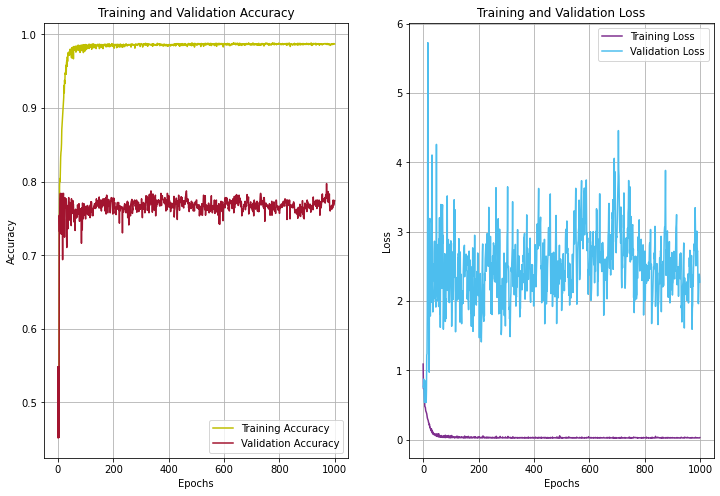

In [ ]:
epochs_range = range(EPOCHS)

fig=plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['acc'], label='Training Accuracy', color=[0.75, 0.75, 0])
plt.plot(epochs_range, history.history['val_acc'], label='Validation Accuracy', color= 	[0.6350, 0.0780, 0.1840])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss', color=	[0.4940, 0.1840, 0.5560])
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', color= [0.3010, 0.7450, 0.9330])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()
fig.savefig('TrainingHistory_GRU_1.pdf')

In [ ]:
# test data for test_accuracy
loss, accuracy = model_GRU_6.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy*100))

val_loss, val_accuracy = model_GRU_6.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(val_accuracy*100))

Training Accuracy: 94.4877
Testing Accuracy:  78.5572


##Model 8 - Gated Recurrent Unit

Increased drop out and rearranged layers

In [ ]:
model_GRU_7 = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_matrix.shape[1], input_length = MAX_LEN, weights = [embedding_matrix],
                             trainable = False),   
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64 ,return_sequences=True,dropout = 0.4, recurrent_dropout = 0.4)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64 ,return_sequences=True,dropout = 0.4, recurrent_dropout = 0.4)),   
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(units=8, activation="relu"),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(units=1, activation="sigmoid")   
])
model_GRU_7.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           1706800   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50, 128)           63744     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 50, 128)           74496     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
dense_15 (Dense)             (None, 50, 8)             1032      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 8)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                

In [ ]:
model_GRU_7.compile(loss = 'binary_crossentropy',  optimizer = tf.keras.optimizers.RMSprop(lr=4*0.0001), metrics = ['acc'])

In [ ]:

# early stopping the training if the loss is not decreasing with patience value as 5.
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# scheduling the learning rate.
def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

learning_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
#define early stopping callback

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


In [ ]:
history=model_GRU_7.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split = .2,verbose=1, callbacks=[callback])

Epoch 1/1000
 2/10 [=====>........................] - ETA: 0s - loss: 0.7634 - acc: 0.5723WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0012s vs `on_train_batch_end` time: 0.2288s). Check your callbacks.


10/10 [==============================] - ETA: 0s - loss: 0.6828 - acc: 0.5919WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0009s vs `on_test_batch_end` time: 0.0563s). Check your callbacks.


10/10 [==============================] - 3s 328ms/step - loss: 0.6828 - acc: 0.5919 - val_loss: 0.6420 - val_acc: 0.6038
Epoch 2/1000
10/10 [==============================] - 2s 202ms/step - loss: 0.5992 - acc: 0.6925 - val_loss: 0.5791 - val_acc: 0.7014
Epoch 3/1000
10/10 [==============================] - 2s 200ms/step - loss: 0.5522 - acc: 0.7334 - val_loss: 0.5535 - val_acc: 0.7196
Epoch 4/1000
10/10 [==============================] - 2s 198ms/step - loss: 0.5272 - acc: 0.7508 - val_loss: 0.5122 - val_acc: 0.7543
Epoch 5/1000
10/10 [==============================] - 2s 198ms/step - loss: 0.5133 - acc: 0.7639 - val_loss: 0.5105 - val_acc: 0.7552
Epoch 6/1000
10/10 [==============================] - 2s 202ms/step - loss: 0.5044 - acc: 0.7639 - val_loss: 0.4866 - val_acc: 0.7725
Epoch 7/1000
10/10 [==============================] - 2s 198ms/step - loss: 0.4980 - acc: 0.7690 - val_loss: 0.4985 - val_acc: 0.7568
Epoch 8/1000
10/10 [==============================] - 2s 199ms/step - loss:

In [ ]:
# Ref : https://stackoverflow.com/questions/51463383/buffered-data-was-truncated-after-reaching-the-output-size-limit
#model_GRU_7.save('model_GRU_7.h5')
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(15)

,loss,acc,val_loss,val_acc,epoch
22,0.448012,0.797599,0.482165,0.775848,22
23,0.448453,0.799255,0.497314,0.770058,23
24,0.449619,0.795737,0.510293,0.771712,24
25,0.447533,0.806498,0.482986,0.774194,25
26,0.451967,0.797392,0.485888,0.775848,26
27,0.445512,0.800704,0.491976,0.770058,27
28,0.445209,0.802359,0.471371,0.779983,28
29,0.447696,0.801324,0.477106,0.777502,29
30,0.443062,0.804015,0.483924,0.771712,30
31,0.440618,0.807947,0.470521,0.784946,31


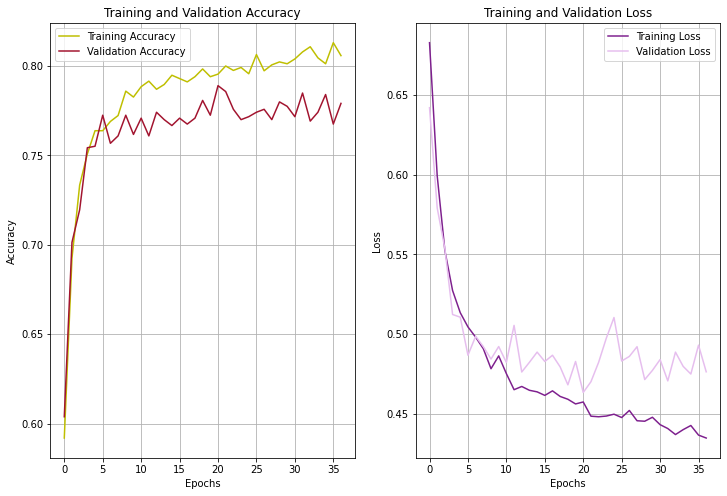

In [ ]:
epochs_range = range(37)

fig=plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['acc'], label='Training Accuracy', color=[0.75, 0.75, 0])
plt.plot(epochs_range, history.history['val_acc'], label='Validation Accuracy', color= 	[0.6350, 0.0780, 0.1840])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss', color=	[0.4940, 0.1240, 0.5560])
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', color= [0.9010, 0.7450, 0.9330])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()
fig.savefig('TrainingHistory_GRU_2.pdf')

In [ ]:
# test data for test_accuracy
loss, accuracy = model_GRU_7.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy*100))

val_loss, val_accuracy = model_GRU_7.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(val_accuracy*100))

Training Accuracy: 81.0462
Testing Accuracy:  82.0649


In [ ]:
model_GRU_7.save('model_GRU_7_82.h5')

In [ ]:
y_pred_gru = model_GRU_7.predict(X_test)
y_pred_gru_round = y_pred_gru.round().astype('int')
# Classification Reports
report_rfc = classification_report(y_test, y_pred_gru_round)
print(report_rfc)
y_auc = roc_auc_score(y_test, y_pred_gru_round)
print('GRU: ROC AUC=%.3f' % (y_auc))


              precision    recall  f1-score   support

           0       0.86      0.82      0.84       878
           1       0.77      0.82      0.79       633

    accuracy                           0.82      1511
   macro avg       0.82      0.82      0.82      1511
weighted avg       0.82      0.82      0.82      1511

GRU: ROC AUC=0.820


In [ ]:
# Loading the saved model
model_GRU_7 = tf.keras.models.load_model("model_GRU_7_82.h5")
y_score = model_GRU_7.predict(X_test)

<Figure size 864x576 with 0 Axes>

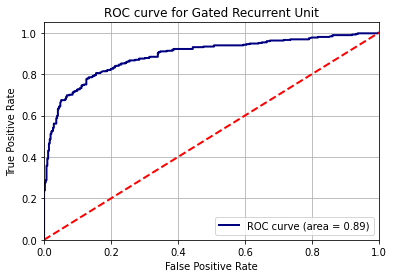

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test,y_score)
roc_auc = auc(fpr, tpr)
fig=plt.figure(figsize=(12, 8))
plt.figure()
plt.plot(fpr, tpr, color= 'navy', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color= 'red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.title('ROC curve for Gated Recurrent Unit')
plt.legend(loc="lower right")
plt.show()


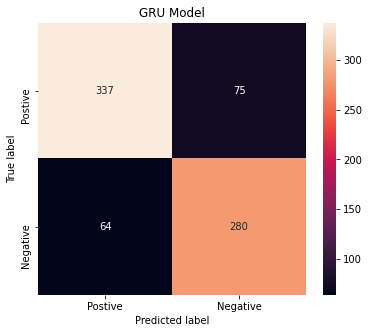

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
y_score_round = y_score.round().astype('int')
# Creates a confusion matrix
cm = confusion_matrix(y_test,y_score_round) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Postive','Negative'], 
                     columns = ['Postive','Negative'])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('GRU Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
print(confusion_matrix(y_test,y_score_round) )

[[337  75]
 [ 64 280]]


##Model 9 - Gated Recurrent Unit(Better)

Adding the learning rate scheduler to try out to smooth out the graph

In [ ]:
model_GRU_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_matrix.shape[1], input_length = MAX_LEN, weights = [embedding_matrix],
                             trainable = False),   
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64 ,return_sequences=True,dropout = 0.4, recurrent_dropout = 0.4)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64 ,return_sequences=True,dropout = 0.6, recurrent_dropout = 0.6)),   
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(units=16, activation="elu"),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(units=1, activation="sigmoid")   
])
model_GRU_3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 100)           1706800   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 50, 128)           63744     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 50, 128)           74496     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
dense_21 (Dense)             (None, 50, 16)            2064      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                

In [ ]:
model_GRU_3.compile(loss = 'binary_crossentropy',  optimizer = tf.keras.optimizers.RMSprop(lr=4*0.0001), metrics = ['acc'])

In [ ]:
# early stopping the training if the loss is not decreasing with patience value as 20.
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
#lr=4*0.0001
# scheduling the learning rate.
def scheduler(epoch):
  if epoch < 100:
    return 4*0.0001
  else:
    return epoch*0.000001

learning_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
#define early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
history=model_GRU_3.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=100,validation_split = .2,verbose=2)

Epoch 1/100


10/10 - 5s - loss: 0.6353 - acc: 0.6478 - val_loss: 0.5881 - val_acc: 0.6907
Epoch 2/100
10/10 - 2s - loss: 0.5674 - acc: 0.7200 - val_loss: 0.5443 - val_acc: 0.7295
Epoch 3/100
10/10 - 2s - loss: 0.5339 - acc: 0.7471 - val_loss: 0.5016 - val_acc: 0.7684
Epoch 4/100
10/10 - 2s - loss: 0.5113 - acc: 0.7595 - val_loss: 0.4913 - val_acc: 0.7758
Epoch 5/100
10/10 - 2s - loss: 0.5032 - acc: 0.7661 - val_loss: 0.4991 - val_acc: 0.7568
Epoch 6/100
10/10 - 2s - loss: 0.4985 - acc: 0.7692 - val_loss: 0.4774 - val_acc: 0.7734
Epoch 7/100
10/10 - 2s - loss: 0.4933 - acc: 0.7728 - val_loss: 0.4741 - val_acc: 0.7767
Epoch 8/100
10/10 - 2s - loss: 0.4888 - acc: 0.7744 - val_loss: 0.4848 - val_acc: 0.7667
Epoch 9/100
10/10 - 2s - loss: 0.4769 - acc: 0.7825 - val_loss: 0.4668 - val_acc: 0.7883
Epoch 10/100
10/10 - 2s - loss: 0.4770 - acc: 0.7864 - val_loss: 0.4941 - val_acc: 0.7626
Epoch 11/100
10/10 - 2s - loss: 0.4673 - acc: 0.7864 - val_loss: 0.4704 - val_acc: 0.7775
Epoch 12/100
10/10 - 2s - loss:

In [ ]:
# Ref : https://stackoverflow.com/questions/51463383/buffered-data-was-truncated-after-reaching-the-output-size-limit
#model_GRU_7.save('model_GRU_7.h5')
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(15)

,loss,acc,val_loss,val_acc,epoch
85,0.404561,0.823262,0.457453,0.794872,85
86,0.414725,0.819122,0.448256,0.798180,86
87,0.408003,0.821399,0.465959,0.791563,87
88,0.409630,0.821192,0.453137,0.792390,88
89,0.410888,0.814570,0.463310,0.792390,89
90,0.410273,0.818295,0.459009,0.794045,90
91,0.407125,0.821192,0.451179,0.794872,91
92,0.408832,0.820778,0.443532,0.790736,92
93,0.408061,0.819536,0.445055,0.799007,93
94,0.405293,0.814363,0.504569,0.773366,94


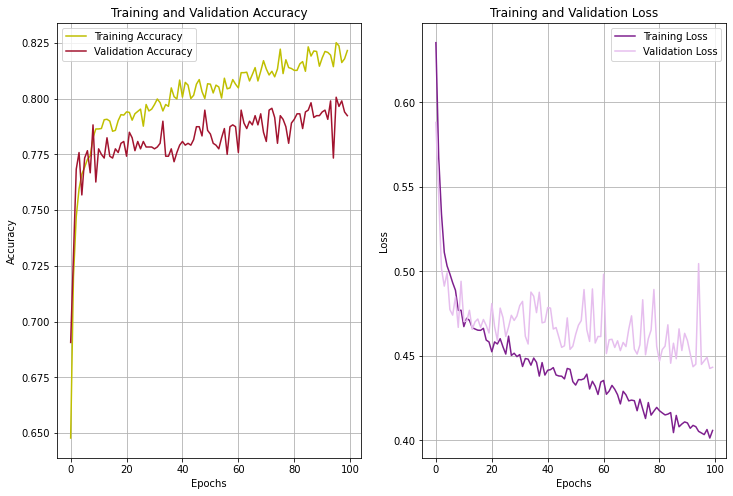

In [ ]:
epochs_range = range(100)

fig=plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['acc'], label='Training Accuracy', color=[0.75, 0.75, 0])
plt.plot(epochs_range, history.history['val_acc'], label='Validation Accuracy', color= 	[0.6350, 0.0780, 0.1840])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss', color=	[0.4940, 0.1240, 0.5560])
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', color= [0.9010, 0.7450, 0.9330])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()
fig.savefig('TrainingHistory_GRU_3.pdf')

In [ ]:
# test data for test_accuracy
loss, accuracy = model_GRU_3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy*100))

val_loss, val_accuracy = model_GRU_3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(val_accuracy*100))

Training Accuracy: 83.3306
Testing Accuracy:  82.9252


In [ ]:
y_pred_gru = model_GRU_3.predict(X_test)
y_pred_gru_round = y_pred_gru.round().astype('int')
# Classification Reports
report_rfc = classification_report(y_test, y_pred_gru_round)
print(report_rfc)
y_auc = roc_auc_score(y_test, y_pred_gru_round)
print('GRU: ROC AUC=%.3f' % (y_auc))


              precision    recall  f1-score   support

           0       0.82      0.91      0.86       878
           1       0.85      0.72      0.78       633

    accuracy                           0.83      1511
   macro avg       0.83      0.81      0.82      1511
weighted avg       0.83      0.83      0.83      1511

GRU: ROC AUC=0.814


In [ ]:
model_GRU_3.save('model_GRU_3_82_9.h5')

In [ ]:
# Loading the saved model
model_GRU_3 = tf.keras.models.load_model("model_GRU_3_82_9.h5")
y_score = model_GRU_3.predict(X_test)

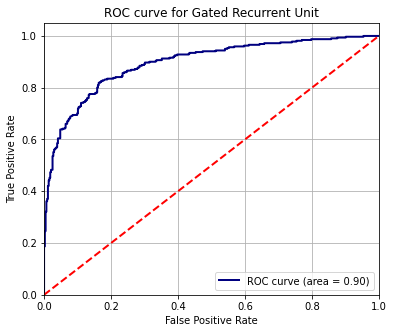

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test,y_score)
roc_auc = auc(fpr, tpr)
fig=plt.figure(figsize=(6, 5))
#plt.figure()
plt.plot(fpr, tpr, color= 'navy', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color= 'red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.title('ROC curve for Gated Recurrent Unit')
plt.legend(loc="lower right")
plt.show()
fig.savefig('ROC_GRU.pdf')

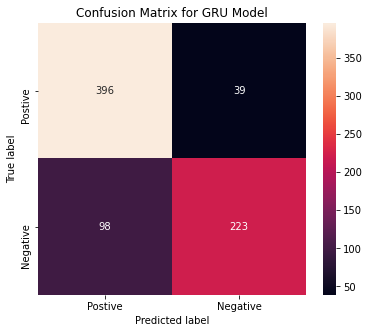

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
y_score_round = y_score.round().astype('int')
# Creates a confusion matrix
cm = confusion_matrix(y_test,y_score_round) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Postive','Negative'], 
                     columns = ['Postive','Negative'])

fig = plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('Confusion Matrix for GRU Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
fig.savefig('ConfusionMatrix_GRU.pdf')

In [ ]:
print(confusion_matrix(y_test,y_score_round) )

[[252 160]
 [162 182]]


##Model 10 - Gated Recurrent Unit

In [ ]:
model_GRU_8 = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_matrix.shape[1], input_length = MAX_LEN, weights = [embedding_matrix],
                             trainable = False),   
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64 ,return_sequences=True,dropout = 0.4, recurrent_dropout = 0.4)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64 ,return_sequences=True,dropout = 0.4, recurrent_dropout = 0.4)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(units=1, activation="sigmoid")   
])
model_GRU_8.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 100)           1706800   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 50, 128)           63744     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 50, 128)           74496     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 128)           0         
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 129       
Total params: 1,845,169
Trainable params: 138,369
Non-trainable params: 1,706,800
______________________________________

In [ ]:
model_GRU_8.compile(loss = 'binary_crossentropy',  optimizer = tf.keras.optimizers.RMSprop(lr=4*0.0001), metrics = ['acc'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

In [ ]:
history=model_GRU_8.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split = .2,verbose=1,callbacks = [callback])

Epoch 1/1000
 2/10 [=====>........................] - ETA: 0s - loss: 0.6818 - acc: 0.5752WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0038s vs `on_train_batch_end` time: 0.2261s). Check your callbacks.


10/10 [==============================] - ETA: 0s - loss: 0.6166 - acc: 0.6660WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0007s vs `on_test_batch_end` time: 0.0556s). Check your callbacks.


10/10 [==============================] - 3s 295ms/step - loss: 0.6166 - acc: 0.6660 - val_loss: 0.6002 - val_acc: 0.7370
Epoch 2/1000
10/10 [==============================] - 2s 200ms/step - loss: 0.5372 - acc: 0.7419 - val_loss: 0.5589 - val_acc: 0.7634
Epoch 3/1000
10/10 [==============================] - 2s 201ms/step - loss: 0.5021 - acc: 0.7647 - val_loss: 0.5327 - val_acc: 0.7783
Epoch 4/1000
10/10 [==============================] - 2s 200ms/step - loss: 0.4906 - acc: 0.7742 - val_loss: 0.5244 - val_acc: 0.7659
Epoch 5/1000
10/10 [==============================] - 2s 201ms/step - loss: 0.4816 - acc: 0.7794 - val_loss: 0.5156 - val_acc: 0.7808
Epoch 6/1000
10/10 [==============================] - 2s 200ms/step - loss: 0.4768 - acc: 0.7794 - val_loss: 0.5129 - val_acc: 0.7758
Epoch 7/1000
10/10 [==============================] - 2s 201ms/step - loss: 0.4748 - acc: 0.7844 - val_loss: 0.5077 - val_acc: 0.7775
Epoch 8/1000
10/10 [==============================] - 2s 201ms/step - loss:

In [ ]:
import pandas as pd

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(15)

,loss,acc,val_loss,val_acc,epoch
167,0.301287,0.876449,0.455758,0.790736,167
168,0.316157,0.869826,0.462599,0.779156,168
169,0.312678,0.865687,0.455021,0.789082,169
170,0.308656,0.864238,0.460943,0.784946,170
171,0.307578,0.866722,0.463266,0.776675,171
172,0.309110,0.865480,0.476061,0.767577,172
173,0.313018,0.861755,0.456418,0.798180,173
174,0.300520,0.872724,0.461397,0.779156,174
175,0.295528,0.872103,0.453421,0.791563,175
176,0.305959,0.875621,0.463017,0.776675,176


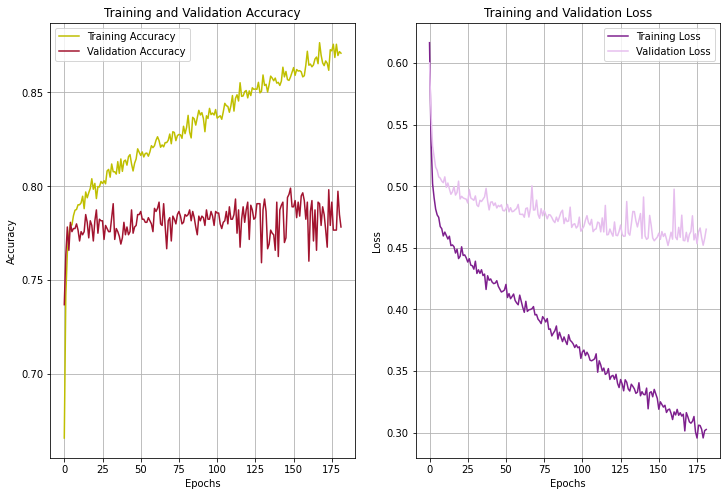

In [ ]:
epochs_range = range(182)

fig=plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['acc'], label='Training Accuracy', color=[0.75, 0.75, 0])
plt.plot(epochs_range, history.history['val_acc'], label='Validation Accuracy', color= 	[0.6350, 0.0780, 0.1840])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss', color=	[0.4940, 0.1240, 0.5560])
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', color= [0.9010, 0.7450, 0.9330])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()
fig.savefig('TrainingHistory_GRU_4.pdf')

In [ ]:
# test data for test_accuracy
loss, accuracy = model_GRU_8.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy*100))

val_loss, val_accuracy = model_GRU_8.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(val_accuracy*100))

Training Accuracy: 88.4787
Testing Accuracy:  81.0721


In [ ]:
model_GRU_8.save('model_GRU_8.h5')

#Transfer Learning for NLP


Ref: https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270

Ref : https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub

Ref : http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

Ref : https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2

##Setting up BERT


Bidirectional Encoder Representations from Transformers (BERT) is a technique for NLP (Natural Language Processing) pre-training developed by Google. 
A pre-trained BERT model can be fine-tuned with just one additional output layer to create good models.

In [ ]:
# The official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 10.2MB/s 
     |████████████████████████████████| 3.0MB 19.4MB/s 
     |████████████████████████████████| 890kB 44.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=f4bafd81f48ed19a931d970148f465c8fa647e1a8067c0457b16df27715fedbc
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip install -q -U tf-hub-nightly
!pip install -q tfds-nightly

     |████████████████████████████████| 112kB 2.8MB/s 
     |████████████████████████████████| 3.4MB 2.6MB/s 


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tokenization
from tensorflow import keras


##Using BERT - 1

In [ ]:
#Ref Source for bert_encode function: https://www.kaggle.com/user123454321/bert-starter-inference
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

The BERT tokenizer does a pretty good preprocessing job by itself, 
therefore the input text is tokenized directly without any previous cleaning/preprocessing.

In [ ]:
train_df_master = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Kaggle/train.csv")
test_df_master = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Kaggle/test.csv")

In [ ]:
train_df_master[5000:]

,id,keyword,location,text,target
5000,7132,military,NY,13 reasons why we love women in the military ...,0
5001,7134,military,302,13 reasons why we love women in the military ...,0
5002,7135,military,NaN,@UniversityofLaw For the people who died in Hu...,1
5003,7136,military,NaN,Lot of 20 Tom Clancy Military Mystery Novels -...,0
5004,7137,military,NaN,@CochiseCollege For the people who died in Hum...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
train_df = train_df_master.drop('location', axis=1)

In [ ]:
train= train_df[:6500]
test=train_df[6500:]

In [ ]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 22.4 s, sys: 3.86 s, total: 26.3 s
Wall time: 39.7 s


In [ ]:
#Load tokenizer from the bert layer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

The model configuration did not use any Dense layer. Simply added a sigmoid output directly to the last layer of BERT.

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model([input_word_ids, input_mask, segment_ids], out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
model = build_model(bert_layer, max_len=160)

In [ ]:
bert_model5.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer_3 (KerasLayer)      [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
checkpoint = ModelCheckpoint('bert_model5.h5', monitor='val_loss', save_best_only=True)

train_history = bert_model5.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=2,
    callbacks=[checkpoint],
    batch_size=2
)

Epoch 1/2
3045/3045 [==============================] - 2061s 677ms/step - loss: 0.4425 - accuracy: 0.8089 - val_loss: 0.3740 - val_accuracy: 0.8496
Epoch 2/2
3045/3045 [==============================] - 1948s 640ms/step - loss: 0.3302 - accuracy: 0.8731 - val_loss: 0.3841 - val_accuracy: 0.8431


In [ ]:
bert_model5.save('bert_model5_1.h5')

In [ ]:
import pandas as pd

hist = pd.DataFrame(train_history.history)
hist['epoch'] = train_history.epoch
hist.tail(15)

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.442528,0.808867,0.374048,0.849639,0
1,0.330193,0.873071,0.384058,0.843073,1


In [ ]:
model = build_model(bert_layer, max_len=160)
model.load_weights('bert_model5_1.h5')

In [ ]:
test_pred_1 = model.predict(test_input)
test_pred_BERT_int_1 = test_pred_1.round().astype('int')

In [ ]:
# test data for test_accuracy
loss, accuracy = model.evaluate(train_input, train_labels, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy*100))

val_loss, val_accuracy = model.evaluate(test_input, test_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(val_accuracy*100))

Training Accuracy: 92.9231
Testing Accuracy:  83.1087


In [ ]:
from sklearn.metrics import roc_auc_score
# Classification Reports
report_rfc = classification_report(test_labels, test_pred_BERT_int_1)
print(report_rfc)
y_auc = roc_auc_score(test_labels, test_pred_BERT_int_1)
print('BERT : ROC AUC=%.3f' % (y_auc))


              precision    recall  f1-score   support

           0       0.83      0.85      0.84       586
           1       0.83      0.81      0.82       527

    accuracy                           0.83      1113
   macro avg       0.83      0.83      0.83      1113
weighted avg       0.83      0.83      0.83      1113

GRU: ROC AUC=0.830


In [ ]:
y_test = test_labels
y_score = test_pred_1

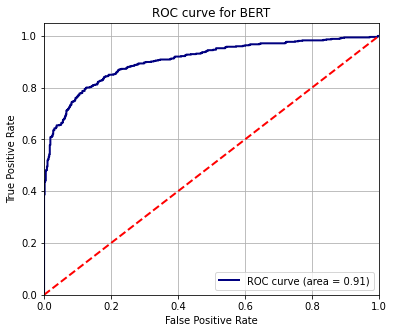

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test,y_score)
roc_auc = auc(fpr, tpr)
fig=plt.figure(figsize=(6, 5))
#plt.figure()
plt.plot(fpr, tpr, color= 'navy', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color= 'red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.title('ROC curve for BERT')
plt.legend(loc="lower right")
plt.show()
fig.savefig('ROC_BERT.pdf')

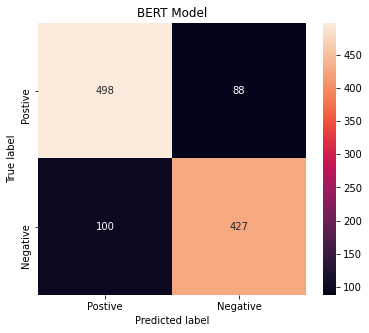

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
y_score_round = y_score.round().astype('int')
# Creates a confusion matrix
cm = confusion_matrix(y_test,y_score_round) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Postive','Negative'], 
                     columns = ['Postive','Negative'])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('BERT Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
fig.savefig('ConfusionMatrix_BERT.pdf')

## Using BERT - 2 (Better)

In [ ]:
checkpoint = ModelCheckpoint('bert_model5.h5', monitor='val_loss', save_best_only=True)

train_history = bert_model5.fit(
    train_input, train_labels,
    validation_split=0.15,
    epochs=2,
    callbacks=[checkpoint],
    batch_size=2
)

Epoch 1/2
2763/2763 [==============================] - 860s 311ms/step - loss: 0.3479 - accuracy: 0.8737 - val_loss: 0.3882 - val_accuracy: 0.8328
Epoch 2/2
2763/2763 [==============================] - 783s 283ms/step - loss: 0.3152 - accuracy: 0.8871 - val_loss: 0.4106 - val_accuracy: 0.8462


In [ ]:
import pandas as pd

hist = pd.DataFrame(train_history.history)
hist['epoch'] = train_history.epoch
hist.tail(15)


,loss,accuracy,val_loss,val_accuracy,epoch
0,0.347933,0.873665,0.388234,0.832821,0
1,0.315175,0.887059,0.410591,0.846154,1


In [ ]:
test_pred = bert_model5.predict(test_input)

In [ ]:
test_pred_1 = model.predict(test_input)
test_pred_BERT_int_1 = test_pred_1.round().astype('int')

In [ ]:
# test data for test_accuracy
loss, accuracy = model.evaluate(train_input, train_labels, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy*100))

val_loss, val_accuracy = model.evaluate(test_input, test_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(val_accuracy*100))

Training Accuracy: 88.1385
Testing Accuracy:  80.1438


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(val.target, val_pred_BERT_int))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1436
           1       0.89      0.84      0.86      1177

    accuracy                           0.88      2613
   macro avg       0.88      0.88      0.88      2613
weighted avg       0.88      0.88      0.88      2613



In [ ]:
y_test = test_labels
y_score = test_pred_1

<Figure size 864x576 with 0 Axes>

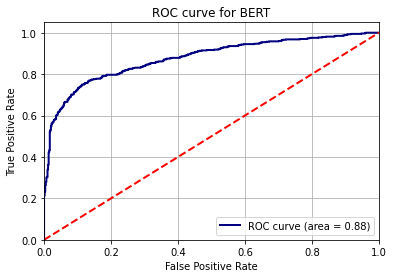

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test,y_score)
roc_auc = auc(fpr, tpr)
fig=plt.figure(figsize=(12, 8))
plt.figure()
plt.plot(fpr, tpr, color= 'navy', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color= 'red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.title('ROC curve for BERT')
plt.legend(loc="lower right")
plt.show()
fig.savefig('ROC_BERT.pdf')

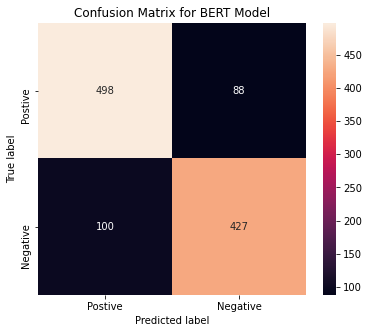

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
y_score_round = y_score.round().astype('int')
# Creates a confusion matrix
cm = confusion_matrix(y_test,y_score_round) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Postive','Negative'], 
                     columns = ['Postive','Negative'])

fig = plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('Confusion Matrix for BERT Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
fig.savefig('ConfusionMatrix_BERT.pdf')

In [ ]:
test_pred = model.predict(test_input)
submission['target'] = test_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)

#Model Comparison

In [ ]:
Comparison_df_2 = pd.read_excel("/content/ModelComparison1.xlsx")

In [ ]:
Comparison_df_2

,Model Name,Accuracy,WeightedPrecision,Weighted Recall,Weighted F1-score
0,Ensemble,0.81,0.81,0.81,0.81
1,Simple RNN,0.81,0.81,0.81,0.81
2,LSTM,0.83,0.83,0.83,0.83
3,Bidirectional LSTM,0.83,0.83,0.83,0.83
4,GRU,0.83,0.83,0.83,0.83
5,BERT Model,0.88,0.88,0.88,0.88


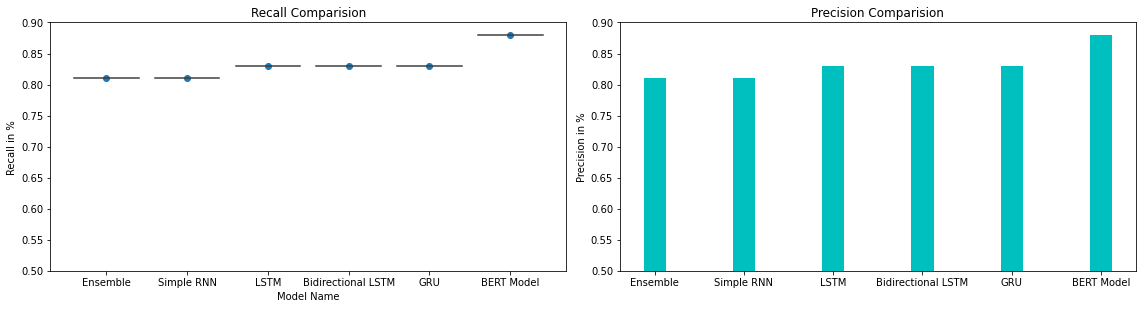

In [ ]:
fig=plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
sns.violinplot(Comparison_df_2["Model Name"], Comparison_df_2["Weighted Recall"], scale='width', inner='quartile')
plt.scatter(Comparison_df_2["Model Name"], Comparison_df_2["Weighted Recall"])
plt.ylim(0.50,0.9)
plt.ylabel('Recall in %')
plt.title('Recall Comparision')


plt.subplot(2,2,2)
plt.bar(Comparison_df_2["Model Name"], Comparison_df_2["WeightedPrecision"], color='c', width=.25)
plt.ylim(0.50,0.9)
plt.ylabel('Precision in %')
plt.title('Precision Comparision')
plt.tight_layout()
fig.savefig("comparision_results_Precision Recall.pdf")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if __name__ == '__main__':


<function matplotlib.pyplot.show>

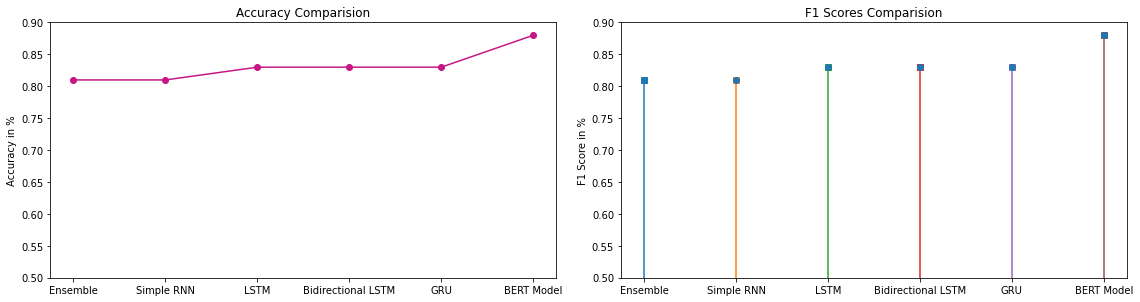

In [ ]:
fig=plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.plot(Comparison_df_2["Model Name"], Comparison_df_2["Accuracy"], marker='o', color='mediumvioletred')
plt.title("Accuracy Comparision")
plt.ylabel('Accuracy in %')
plt.ylim(0.50,0.9)

plt.subplot(2,2,2)
plt.stem(Comparison_df_2["Model Name"], Comparison_df_2["Weighted F1-score"], '-s')
plt.ylim(0.50,0.9)
plt.title("F1 Scores Comparision")
plt.ylabel('F1 Score in %')
plt.tight_layout()
fig.savefig("comparision_results_F1Score_Accuracy.pdf")
plt.show

#Key References



Ref : https://machinelearningmastery.com/gentle-introduction-bag-words-model/

Ref : https://towardsdatascience.com/stemming-vs-lemmatization-2daddabcb221

Ref : https://towardsdatascience.com/a-simple-explanation-of-the-bag-of-words-model-b88fc4f4971

Ref : https://nlp.stanford.edu/projects/glove/

Ref: https://medium.com/analytics-vidhyaword-vectorization-using-glove-76919685ee0b

Ref : https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

Ref : https://stackoverflow.com/questions/43035827/whats-the-difference-between-a-bidirectional-lstm-and-an-lstm

Ref: https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270

Ref : https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub

Ref : http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

Ref : https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2

Ref:https://www.kaggle.com/user123454321/bert-starter-inference